**Fatemeh Mirzaei Kalani**

**400243075**


In [1]:
import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
import torch.nn.functional as F
from torchvision import models

import os
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
from skimage.util import random_noise
from tqdm.notebook import tqdm
from dataclasses import dataclass
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
@dataclass
class Config:
    num_classes = 3
    batch_size = 20
    learning_rate = 0.001
    num_epochs = 15
    num_workers = 2
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data_dir = "/content/drive/MyDrive/Vision/shoes"
    input_size = (128, 128)
    weight_decay = 1e-5 # L2 regularization

config = Config()

In [44]:
def get_transform(train=True):
    if train:
        return transforms.Compose([
            transforms.RandomResizedCrop((128, 128)),  # Random crop and resize
            transforms.RandomHorizontalFlip(),         # Random horizontal flip
            transforms.RandomRotation(15),            # Random rotation within ±15 degrees
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

In [45]:
train_dataset = datasets.ImageFolder(root=os.path.join(config.data_dir, "train"), transform=get_transform(train=True))
test_dataset = datasets.ImageFolder(root=os.path.join(config.data_dir, "test"), transform=get_transform(train=False))


In [46]:
train_dataloader = DataLoader(train_dataset, batch_size = config.batch_size, shuffle = True, num_workers = config.num_workers, pin_memory = True)
test_dataloader = DataLoader(test_dataset, batch_size = config.batch_size, shuffle = True, num_workers = config.num_workers, pin_memory = True)

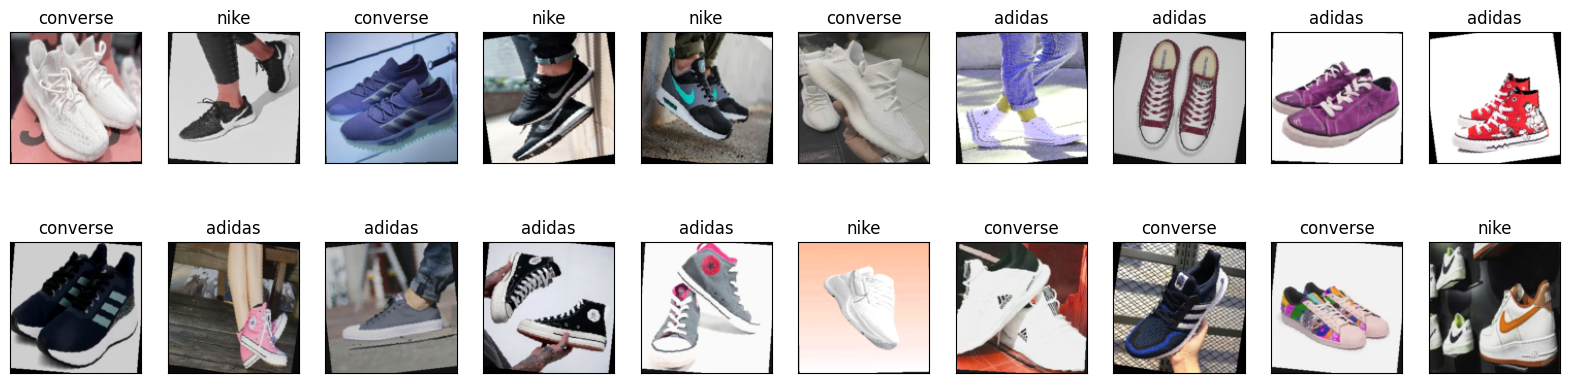

In [37]:
image_dataiter = iter(train_dataloader)
data = next(image_dataiter)
imgs, labels = data

classes= os.listdir(os.path.join(config.data_dir, "train"))

def RGBshow(img):
    img=img*0.5+0.5
    plt.imshow(np.transpose(img,(1,2,0)))

fig=plt.figure(1,figsize=(20,5))
for idx in range(20):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    RGBshow(imgs[idx])
    ax.set_title(classes[labels[idx]])

In [50]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # First Block
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)   # Output: (N, 16, 128, 128)
        self.bn1 = nn.BatchNorm2d(16)                             # Output: (N, 16, 128, 128)
        self.pool1 = nn.MaxPool2d(2)                              # Output: (N, 16, 64, 64)

        # Second Block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Output: (N, 32, 64, 64)
        self.bn2 = nn.BatchNorm2d(32)                             # Output: (N, 32, 64, 64)
        self.pool2 = nn.MaxPool2d(2)                              # Output: (N, 32, 32, 32)
        self.dropout1 = nn.Dropout2d(0.1)

        # Third Block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: (N, 64, 32, 32)
        self.bn3 = nn.BatchNorm2d(64)                             # Output: (N, 64, 32, 32)
        self.pool3 = nn.MaxPool2d(2)                               # Output: (N, 64, 16, 16)

        self.dropout2 = nn.Dropout(0.5)

        # Fully Connected Layer
        self.fc1 = nn.Linear(64 * 16 * 16, config.num_classes)


    def forward(self, x):
        # First Block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        # Second Block
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout1(x)

        # Third Block
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)

        # Flatten and fully connected layer
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.dropout2(x)
        x = self.fc1(x)           # Output layer

        return x


In [51]:
def train_model(model, train_dataloader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(config.device), labels.to(config.device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_dataloader)

In [52]:
def evaluate_model(model, test_dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(config.device), labels.to(config.device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total

    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

    return total_loss / len(test_dataloader), accuracy, precision, recall, f1

In [53]:
def plot_losses(train_losses, test_losses, batch_size, lr):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
    plt.title(f'Loss Curve (Batch Size: {batch_size}, Learning Rate: {lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Training with batch_size=32, learning_rate=0.0005
Epoch [1/15], Train Loss: 2.0342, Test Loss: 1.1052, Accuracy: 40.35%, Precision: 0.2935, Recall: 0.4035, F1 Score: 0.3017
Epoch [2/15], Train Loss: 1.5020, Test Loss: 1.0856, Accuracy: 43.86%, Precision: 0.4341, Recall: 0.4386, F1 Score: 0.4335
Epoch [3/15], Train Loss: 1.4482, Test Loss: 1.0940, Accuracy: 49.12%, Precision: 0.5013, Recall: 0.4912, F1 Score: 0.4624
Epoch [4/15], Train Loss: 1.2788, Test Loss: 1.0294, Accuracy: 44.74%, Precision: 0.4738, Recall: 0.4474, F1 Score: 0.4468
Epoch [5/15], Train Loss: 1.2550, Test Loss: 1.0251, Accuracy: 53.51%, Precision: 0.5453, Recall: 0.5351, F1 Score: 0.5266
Epoch [6/15], Train Loss: 1.3286, Test Loss: 1.1197, Accuracy: 44.74%, Precision: 0.4176, Recall: 0.4474, F1 Score: 0.3862
Epoch [7/15], Train Loss: 1.3243, Test Loss: 1.0897, Accuracy: 43.86%, Precision: 0.4298, Recall: 0.4386, F1 Score: 0.3847
Epoch [8/15], Train Loss: 1.3977, Test Loss: 1.1644, Accuracy: 43.86%, Precision: 0.2949,

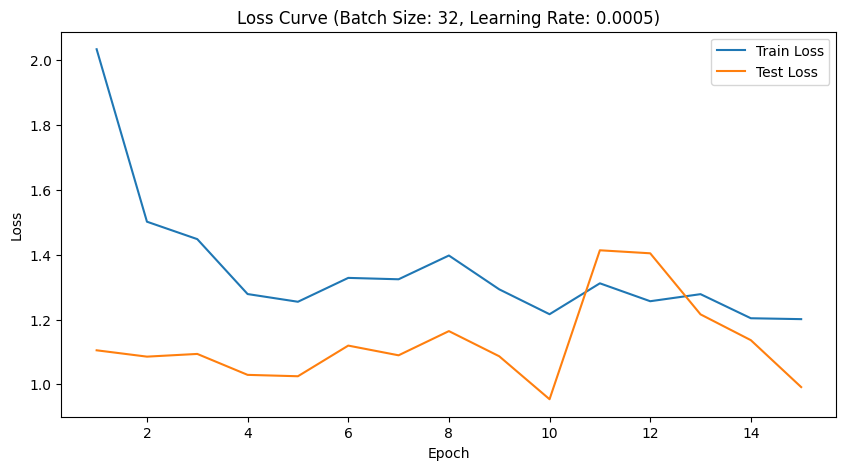

Training with batch_size=32, learning_rate=0.001
Epoch [1/15], Train Loss: 2.3069, Test Loss: 1.2657, Accuracy: 39.47%, Precision: 0.6218, Recall: 0.3947, F1 Score: 0.2874
Epoch [2/15], Train Loss: 1.5630, Test Loss: 1.4720, Accuracy: 36.84%, Precision: 0.4200, Recall: 0.3684, F1 Score: 0.2612
Epoch [3/15], Train Loss: 1.7097, Test Loss: 2.2323, Accuracy: 38.60%, Precision: 0.3589, Recall: 0.3860, F1 Score: 0.2791
Epoch [4/15], Train Loss: 1.6695, Test Loss: 1.3804, Accuracy: 40.35%, Precision: 0.2689, Recall: 0.4035, F1 Score: 0.3227
Epoch [5/15], Train Loss: 1.4507, Test Loss: 1.2430, Accuracy: 40.35%, Precision: 0.4356, Recall: 0.4035, F1 Score: 0.3462
Epoch [6/15], Train Loss: 1.4666, Test Loss: 1.4290, Accuracy: 42.98%, Precision: 0.2978, Recall: 0.4298, F1 Score: 0.3323
Epoch [7/15], Train Loss: 1.4644, Test Loss: 1.3333, Accuracy: 42.11%, Precision: 0.6688, Recall: 0.4211, F1 Score: 0.3233
Epoch [8/15], Train Loss: 1.4440, Test Loss: 1.0353, Accuracy: 48.25%, Precision: 0.6088, 

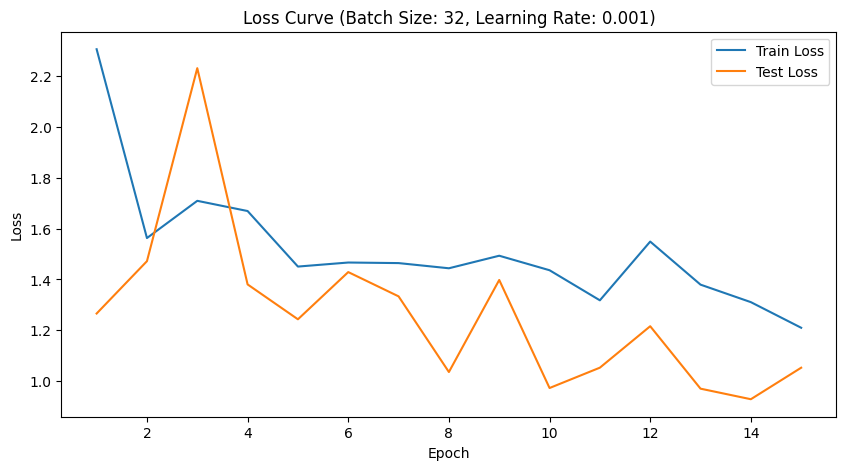

Training with batch_size=64, learning_rate=0.0005
Epoch [1/15], Train Loss: 2.3452, Test Loss: 1.2725, Accuracy: 33.33%, Precision: 0.1111, Recall: 0.3333, F1 Score: 0.1667
Epoch [2/15], Train Loss: 1.7378, Test Loss: 1.3680, Accuracy: 42.11%, Precision: 0.3502, Recall: 0.4211, F1 Score: 0.3107
Epoch [3/15], Train Loss: 1.5961, Test Loss: 1.1446, Accuracy: 43.86%, Precision: 0.2919, Recall: 0.4386, F1 Score: 0.3496
Epoch [4/15], Train Loss: 1.2625, Test Loss: 1.0600, Accuracy: 45.61%, Precision: 0.5804, Recall: 0.4561, F1 Score: 0.4408
Epoch [5/15], Train Loss: 1.3335, Test Loss: 0.9961, Accuracy: 45.61%, Precision: 0.5015, Recall: 0.4561, F1 Score: 0.4281
Epoch [6/15], Train Loss: 1.2417, Test Loss: 1.1471, Accuracy: 42.98%, Precision: 0.4382, Recall: 0.4298, F1 Score: 0.4090
Epoch [7/15], Train Loss: 1.2207, Test Loss: 1.0289, Accuracy: 49.12%, Precision: 0.4925, Recall: 0.4912, F1 Score: 0.4911
Epoch [8/15], Train Loss: 1.2255, Test Loss: 1.1888, Accuracy: 42.98%, Precision: 0.4937,

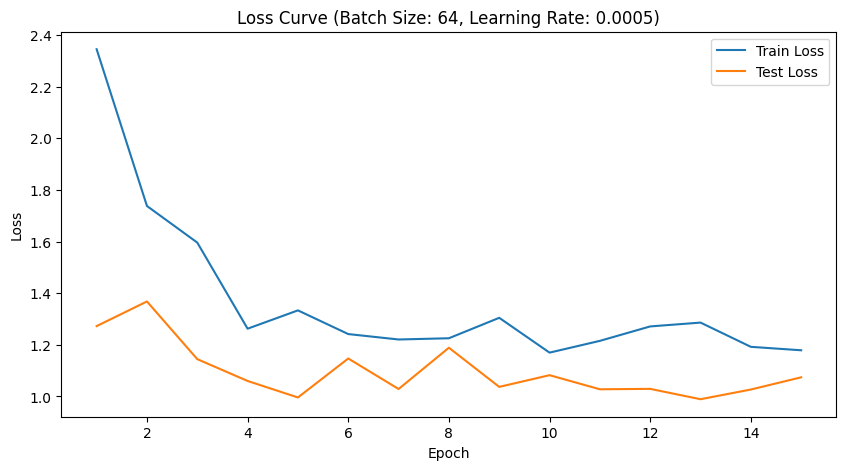

Training with batch_size=64, learning_rate=0.001
Epoch [1/15], Train Loss: 3.4258, Test Loss: 1.1122, Accuracy: 33.33%, Precision: 0.1111, Recall: 0.3333, F1 Score: 0.1667
Epoch [2/15], Train Loss: 2.1377, Test Loss: 1.1887, Accuracy: 42.98%, Precision: 0.2859, Recall: 0.4298, F1 Score: 0.3430
Epoch [3/15], Train Loss: 1.6654, Test Loss: 1.1871, Accuracy: 44.74%, Precision: 0.5955, Recall: 0.4474, F1 Score: 0.3908
Epoch [4/15], Train Loss: 1.4472, Test Loss: 1.3282, Accuracy: 35.96%, Precision: 0.7808, Recall: 0.3596, F1 Score: 0.2204
Epoch [5/15], Train Loss: 1.2593, Test Loss: 1.1294, Accuracy: 41.23%, Precision: 0.3696, Recall: 0.4123, F1 Score: 0.3369
Epoch [6/15], Train Loss: 1.3393, Test Loss: 1.1159, Accuracy: 39.47%, Precision: 0.5249, Recall: 0.3947, F1 Score: 0.3566
Epoch [7/15], Train Loss: 1.3584, Test Loss: 1.5145, Accuracy: 43.86%, Precision: 0.5476, Recall: 0.4386, F1 Score: 0.3897
Epoch [8/15], Train Loss: 1.4672, Test Loss: 1.1134, Accuracy: 43.86%, Precision: 0.4836, 

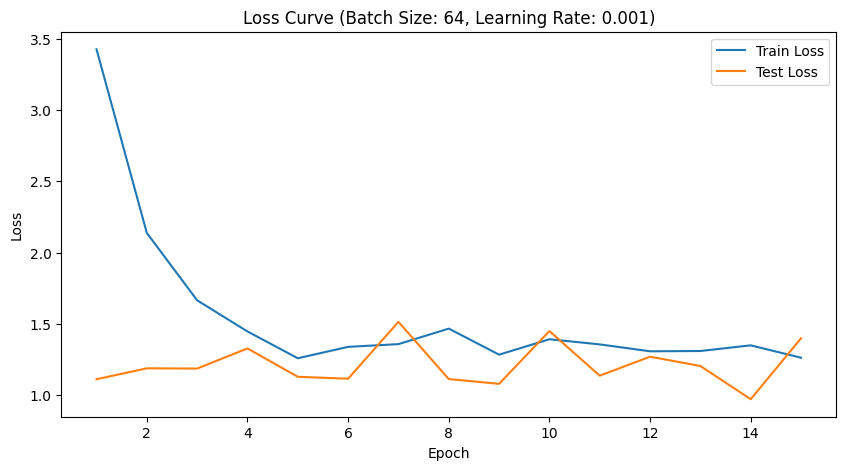


Summary of Results:
Batch Size: 32, Learning Rate: 0.0005, Test Accuracy: 46.49%, Precision: 0.6132, Recall: 0.4649, F1 Score: 0.4441
Batch Size: 32, Learning Rate: 0.001, Test Accuracy: 52.63%, Precision: 0.5878, Recall: 0.5263, F1 Score: 0.4792
Batch Size: 64, Learning Rate: 0.0005, Test Accuracy: 49.12%, Precision: 0.5972, Recall: 0.4912, F1 Score: 0.4538
Batch Size: 64, Learning Rate: 0.001, Test Accuracy: 50.00%, Precision: 0.6578, Recall: 0.5000, F1 Score: 0.4449


In [54]:
results = []
batch_sizes = [32, 64]
learning_rates = [0.0005, 0.001]

for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=config.num_workers,
                                  pin_memory=True)
        test_loader = DataLoader(dataset=test_dataset,
                                 batch_size=batch_size,
                                 shuffle=False,
                                 num_workers=config.num_workers,
                                 pin_memory=True)

        model = CNN().to(config.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=Config.weight_decay)

        print(f"Training with batch_size={batch_size}, learning_rate={learning_rate}")

        train_losses = []
        test_losses = []

        for epoch in range(config.num_epochs):
            train_loss = train_model(model, train_loader, criterion, optimizer)
            test_loss, accuracy, precision, recall, f1 = evaluate_model(model, test_loader, criterion)

            train_losses.append(train_loss)
            test_losses.append(test_loss)

            print(f'Epoch [{epoch+1}/{config.num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

        plot_losses(train_losses, test_losses, batch_size, learning_rate)

        results.append((batch_size, learning_rate, accuracy, precision, recall, f1))

print("\nSummary of Results:")
for batch_size, learning_rate, accuracy, precision, recall, f1 in results:
    print(f"Batch Size: {batch_size}, Learning Rate: {learning_rate}, Test Accuracy: {accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

In [47]:
def get_transfer_learning_model():
    model = models.densenet121(weights='DEFAULT' )

    for param in model.parameters():
        param.requires_grad = False

    # unfreeze all BatchNormalization layers to make them use the new dataset's statistics instead of the original statistics
    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d):
            for param in module.parameters():
                param.requires_grad = True

    # replace the final fully connected layer for our specific task
    classifier = nn.Sequential(nn.Linear(1024, 512),
                     nn.ReLU(),
                     nn.Linear(512, 256),
                     nn.ReLU(),
                     nn.Dropout(0.5),
                     nn.Linear(256, config.num_classes)
                     )

    model.classifier = classifier

    return model

In [49]:
transfered_model = get_transfer_learning_model().to(config.device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(config.device)
optimizer = torch.optim.Adam(transfered_model.parameters(), lr = 0.0005)

for epoch in range(config.num_epochs):
    train_loss = train_model(transfered_model, train_dataloader, criterion, optimizer)
    test_loss, accuracy, precision, recall, f1 = evaluate_model(transfered_model, test_dataloader, criterion)
    print(f'Epoch [{epoch+1}/{config.num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
print("Done!")

Epoch [1/15], Train Loss: 1.0748, Test Loss: 0.9663, Accuracy: 57.02%, Precision: 0.5820, Recall: 0.5702, F1 Score: 0.5582
Epoch [2/15], Train Loss: 0.8898, Test Loss: 0.7140, Accuracy: 70.18%, Precision: 0.7284, Recall: 0.7018, F1 Score: 0.7007
Epoch [3/15], Train Loss: 0.7343, Test Loss: 0.6182, Accuracy: 78.07%, Precision: 0.7984, Recall: 0.7807, F1 Score: 0.7843
Epoch [4/15], Train Loss: 0.7029, Test Loss: 0.5360, Accuracy: 76.32%, Precision: 0.7640, Recall: 0.7632, F1 Score: 0.7575
Epoch [5/15], Train Loss: 0.5892, Test Loss: 0.5049, Accuracy: 78.07%, Precision: 0.7889, Recall: 0.7807, F1 Score: 0.7808
Epoch [6/15], Train Loss: 0.5231, Test Loss: 0.4826, Accuracy: 84.21%, Precision: 0.8517, Recall: 0.8421, F1 Score: 0.8426
Epoch [7/15], Train Loss: 0.4626, Test Loss: 0.4735, Accuracy: 80.70%, Precision: 0.8087, Recall: 0.8070, F1 Score: 0.8049
Epoch [8/15], Train Loss: 0.4711, Test Loss: 0.4676, Accuracy: 87.72%, Precision: 0.8814, Recall: 0.8772, F1 Score: 0.8775
Epoch [9/15], Tr